In [1]:
# %%capture
# !pip install transformers
# !pip install scikit-learn
# ! pip install datasets
# #!pip install allennlp_models

In [2]:
%load_ext autoreload
%autoreload 2

import os, urllib.request, sys, json, random, math, itertools, re, string
from tqdm import tqdm
from typing import List
from enum import Enum, auto

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import EncoderDecoderModel, AutoTokenizer, AutoModelForQuestionAnswering, DataCollatorWithPadding

import datasets
#from allennlp_models.rc.tools import squad

from utils import *

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False


# Using a generator and the following function as `worker_init_fn` preserves reproducibility when using DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def create_reproducible_dataloader(*args, **kwargs):
    generator = torch.Generator()
    return DataLoader(*args,
                      **kwargs,
                      worker_init_fn=seed_worker,
                      generator=generator)

In [4]:
dataset_folder = "coqa/"

# [Task 1] Remove unaswerable QA pairs

## Download the dataset

In [5]:
class DownloadProgressBar(tqdm):

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B',
                             unit_scale=True,
                             miniters=1,
                             desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url,
                                   filename=output_path,
                                   reporthook=t.update_to)


def download_data(data_path, url_path, suffix):
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [6]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=dataset_folder, url_path=train_url, suffix='coqa-train-v1.0')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=dataset_folder, url_path=test_url, suffix='coqa-dev-v1.0')


## Data Inspection

The dataset is very hard to be explored in a Jupyter notebook. To overcome this, we opted to create a more readable version of the dataset, similar to the one provided by the dataset authors.

Prior to this, we performed an automated annotation process, where we assigned each answer a specific answer type:
- `unknown`: unanswerable question - we check if (`span_start`, `span_end`) = (-1, -1)
- `span`: answer overlaps with the passage, after ignoring punctuation and case mismatches
- `yes_no`: answer is Yes or No
- `counting`: answer is the result of a counting process - we check if the answer is a written number or a digit
- `multiple_choice`: answer is one the choices provided in the question - we check if the question has an `or` and contains the answer
- `fluency`: changes to the text span to improve fluency - if the answer is none of the previous, we flag it as `fluency`

Although the automated annotation procedure is susceptible to errors, with some `span` answers being annotated as `counting`, we believe that it is reliable and provides a useful starting point for analyzing the dataset.

We also add the answer type to the question as the most frequent answer type among the provided answers.

In [7]:
class AnswerType(Enum):
    SPAN = auto()
    YES_NO = auto()
    FLUENCY = auto()
    COUNTING = auto()
    MULTIPLE_CHOICE = auto()

    def __str__(self):
        return self.name.lower()

    @classmethod
    def list(cls):
        return list(map(lambda c: str(c), cls))

In [8]:
%%capture

!python3 generate_annotation.py -i coqa/coqa-train-v1.0.json -o coqa/coqa-train-v1.0-annotated.json --readable-file coqa/coqa-train-v1.0-readable.txt  --ignore-additional-answers || \
python generate_annotation.py -i coqa/coqa-train-v1.0.json -o coqa/coqa-train-v1.0-annotated.json --readable-file coqa/coqa-train-v1.0-readable.txt --ignore-additional-answers

!python3 generate_annotation.py -i coqa/coqa-dev-v1.0.json -o coqa/coqa-dev-v1.0-annotated.json --readable-file coqa/coqa-dev-v1.0-readable.txt --ignore-additional-answers || \
python generate_annotation.py -i coqa/coqa-dev-v1.0.json -o coqa/coqa-dev-v1.0-annotated.json --readable-file coqa/coqa-dev-v1.0-readable.txt --ignore-additional-answers

In [9]:
def create_dataframe(train_file, test_file, remove_unknown=True):
    print("Creating the dataframe... ", end="")

    dataset = []
    for split, filename in zip(["train", "test"], [train_file, test_file]):
        with open(os.path.join(dataset_folder, filename)) as f:
            json_data = json.load(f)
            # Collect the data into a DataFrame
            for data in json_data["data"]:
                questions = []
                answers = []
                last_turn = 0
                for question_item, answer_item in zip(data["questions"],
                                                      data["answers"]):
                    last_turn += 1
                    if remove_unknown and question_item[
                            "answer_type"] == "unknown":
                        continue

                    question = parse_question(question_item)
                    answer = parse_answer(answer_item)

                    questions.append(question)
                    answers.append(answer)

                qa_length = len(questions)
                if qa_length > 0:
                    dataset.append({
                        'id': data['id'],
                        'source': data['source'],
                        'filename': data['filename'],
                        'passage': data['story'],
                        'questions': questions,
                        'answers': answers,
                        'qa_length': qa_length,
                        'last_turn': last_turn,
                        'split': split,
                    })

    df = pd.DataFrame(dataset)

    print("Done!")

    print("Checking correctness length of the dataframe...")
    assert df.shape[0] == len(df['id'].unique()), "Something is wrong"

    print("Dataframe created!")
    return df


def parse_question(question_item: dict):
    return {
        "turn": question_item["turn_id"],
        "text": question_item["input_text"],
        "question_type": question_item["answer_type"]
    }


def parse_answer(answer_item: dict):
    return {
        "turn": answer_item["turn_id"],
        "text": answer_item["input_text"],
        "rationale": answer_item["span_text"],
        "span_start": answer_item["span_start"],
        "span_end": answer_item["span_end"],
        "answer_type": answer_item["answer_type"]
    }


df = create_dataframe("coqa-train-v1.0-annotated.json", "coqa-dev-v1.0-annotated.json")
df

Creating the dataframe... Done!
Checking correctness length of the dataframe...
Dataframe created!


,id,source,filename,passage,questions,answers,qa_length,last_turn,split
0,3zotghdk5ibi9cex97fepx7jetpso7,wikipedia,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...","[{'turn': 1, 'text': 'When was the Vat formall...","[{'turn': 1, 'text': 'It was formally establis...",19,20,train
1,3wj1oxy92agboo5nlq4r7bndc3t8a8,cnn,cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...,New York (CNN) -- More than 80 Michael Jackson...,"[{'turn': 1, 'text': 'Where was the Auction he...","[{'turn': 1, 'text': 'Hard Rock Cafe', 'ration...",5,5,train
2,3bdcf01ogxu7zdn9vlrbf2rqzwplyf,gutenberg,data/gutenberg/txt/Zane Grey___Riders of the P...,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...","[{'turn': 1, 'text': 'What did Venters call La...","[{'turn': 1, 'text': 'gun-man', 'rationale': '...",20,20,train
3,3ewijtffvo7wwchw6rtyaf7mfwte0p,cnn,cnn_0c518067e0df811501e46b2e1cd1ce511f1645b7.s...,(CNN) -- The longest-running holiday special s...,"[{'turn': 1, 'text': 'Who is Rudolph's father?...","[{'turn': 1, 'text': 'Donner', 'rationale': 'S...",20,20,train
4,3urfvvm165iantk80llvkwwbjs7uzh,gutenberg,data/gutenberg/txt/Rafael Sabatini___Love-at-A...,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'turn': 1, 'text': 'Who arrived at the churc...","[{'turn': 1, 'text': 'the garrison first', 'ra...",10,10,train
...,...,...,...,...,...,...,...,...,...
7688,3npfyt4izc42dgjyfy8tjwf92engxn,race,high21302.txt,Alan worked in an office in the city. He worke...,"[{'turn': 1, 'text': 'Where does Alan decide t...","[{'turn': 1, 'text': 'William Farm', 'rational...",20,21,test
7689,3a7y0r2p2ooc4i9zn4twg97pt7fjx6,mctest,mc500.test.94,The kitchen comes alive at night in the Sander...,"[{'turn': 1, 'text': 'What is the dad's name?'...","[{'turn': 1, 'text': 'Ryan', 'rationale': 'The...",10,10,test
7690,3o7l7bfshep737ycahi4gj7i1qleiv,wikipedia,A440_(pitch_standard).txt,A440 or A4 (also known as the Stuttgart pitch)...,"[{'turn': 1, 'text': 'What entity standardized...","[{'turn': 1, 'text': 'International Organizati...",20,20,test
7691,3i02618ya06g9pi2dcnttyux9nopu3,race,high22450.txt,"The dog, called Prince, was an intelligent ani...","[{'turn': 1, 'text': 'What is the dog's name?'...","[{'turn': 1, 'text': 'Prince', 'rationale': 'P...",19,19,test


In [10]:
print(f"Number of passages: {len(df)}")
print(f"Number of QA pairs: {df['qa_length'].sum()}")
print(f"Number of files: {len(df['filename'].unique())}")
print()

Number of passages: 7693
Number of QA pairs: 115204
Number of files: 7065



In [11]:
print(f"Columns: {list(df.keys())}")

Columns: ['id', 'source', 'filename', 'passage', 'questions', 'answers', 'qa_length', 'last_turn', 'split']


In [12]:
print(df.loc[0, "passage"])

The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. 

The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. 

In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. 

The Vatican Secret Archives were separated from the library at the beginning of the 17th

In [13]:
print(f"Questions dictionary keys:\t {list(df.loc[0, 'questions'][0].keys())}")
print(f"Answers dictionary keys:\t {list(df.loc[0, 'answers'][0].keys())}")

Questions dictionary keys:	 ['turn', 'text', 'question_type']
Answers dictionary keys:	 ['turn', 'text', 'rationale', 'span_start', 'span_end', 'answer_type']


In [14]:
print("EXAMPLE OF A QUESTION/ANSWER PAIR:\n")
print("Question ->", end=" ")
print(df.loc[0, 'questions'][0])

print("  Answer ->", end=" ")
print(df.loc[0, 'answers'][0])

EXAMPLE OF A QUESTION/ANSWER PAIR:

Question -> {'turn': 1, 'text': 'When was the Vat formally opened?', 'question_type': 'fluency'}
  Answer -> {'turn': 1, 'text': 'It was formally established in 1475', 'rationale': 'Formally established in 1475', 'span_start': 151, 'span_end': 179, 'answer_type': 'fluency'}


In [15]:
print("Conversation Structure:\n")
for idx in range(3):
    print(f"Turn {df.loc[0, 'questions'][idx]['turn']}")
    print(f"Q: {df.loc[0, 'questions'][idx]['text']}")
    print(f"A: {df.loc[0, 'answers'][idx]['text']}")
    print(f"R: {df.loc[0, 'answers'][idx]['rationale']}")
    print()

print("...")
print()
idx = -1
print(f"Turn {df.loc[0, 'questions'][idx]['turn']}")
print(f"Q: {df.loc[0, 'questions'][idx]['text']}")
print(f"A: {df.loc[0, 'answers'][idx]['text']}")
print(f"R: {df.loc[0, 'answers'][idx]['rationale']}")
print()

Conversation Structure:

Turn 1
Q: When was the Vat formally opened?
A: It was formally established in 1475
R: Formally established in 1475

Turn 2
Q: what is the library for?
A: research
R: he Vatican Library is a research library

Turn 3
Q: for what subjects?
A: history, and law
R: Vatican Library is a research library for history, law

...

Turn 20
Q: what will this allow?
A: them to be viewed online.
R: manuscripts, to be made available online. 



In [16]:
print("Distribution of splits: ")
split_counts = df['split'].value_counts()
print(split_counts)

Distribution of splits: 
train    7193
test      500
Name: split, dtype: int64


In [17]:
print("Conversations with gaps in the history (%)")
broken_hist_counts = df[df["qa_length"] < df["last_turn"]]["split"].value_counts()
print(broken_hist_counts / split_counts * 100)

Conversations with gaps in the history (%)
train    15.584596
test     11.600000
Name: split, dtype: float64


<Axes: title={'center': 'Conversation length'}, xlabel='qa_length', ylabel='split'>

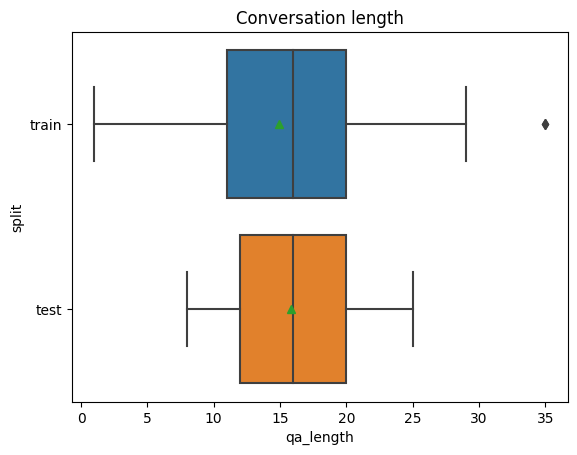

In [18]:
plt.title("Conversation length")
sns.boxplot(data=df, x="qa_length", y="split", showmeans=True)

      passage_length                                                          
               count      mean        std    min     25%    50%    75%     max
split                                                                         
test           500.0  261.8220  71.018995  124.0  221.75  261.0  292.0   804.0
train         7193.0  271.0228  64.901153   70.0  245.00  266.0  293.0  1030.0


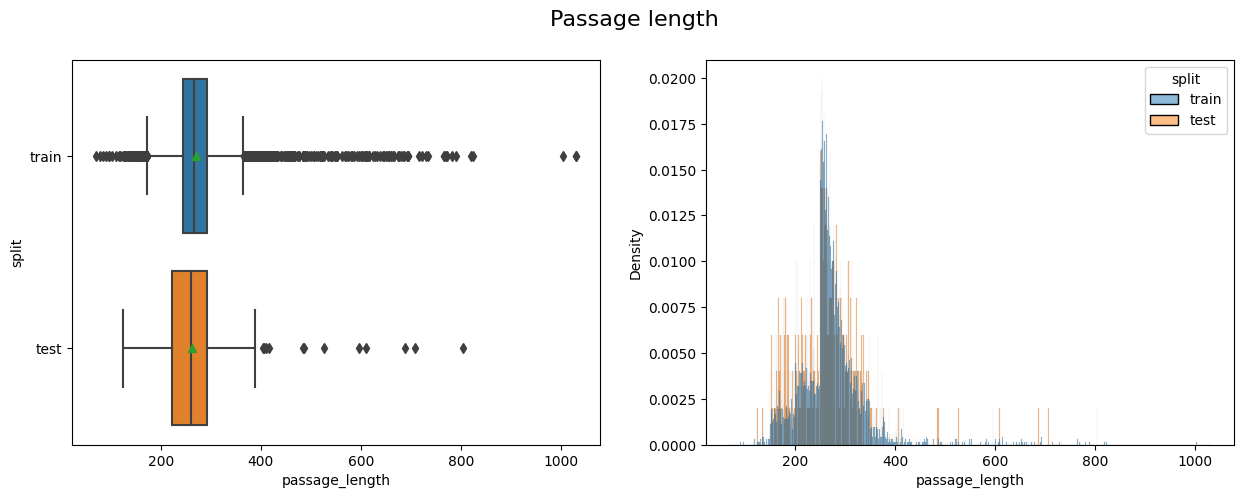

In [19]:
def plot_length(dataset: pd.DataFrame, column: str):
    length_col = column + "_length"
    length = dataset[column].str.split().apply(len)
    dp = dataset[["split"]].copy()
    dp[length_col] = length

    print(dp.groupby("split").describe())
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(data=dp, x=length_col, y="split", showmeans=True, ax=axes[0])
    sns.histplot(dp, x=length_col, hue="split", stat="density", common_norm=False, discrete=True, ax=axes[1])
    fig.suptitle(f"{column.capitalize()} length", fontsize=16)

plot_length(df, "passage");

To analyze questions, answers and rationales, let's explode them.

In [20]:
def explode_qa(dataset: pd.DataFrame):
    dataset = dataset.explode(["questions", "answers"])
    dataset.rename(columns={
        "questions": "question",
        "answers": "answer"
    },
                   inplace=True)

    questions = pd.json_normalize(dataset["question"])
    questions = questions[["turn", "text"]]
    questions.rename(columns={"text": "question"}, inplace=True)

    answers = pd.json_normalize(dataset["answer"])
    answers = answers[[
        "text", "rationale", "span_start", "span_end", "answer_type"
    ]]
    answers.rename(columns={"text": "answer"}, inplace=True)

    dataset.reset_index(inplace=True)
    dataset.drop(["index", "question", "answer"], axis=1, inplace=True)
    dataset = dataset.join(questions)
    dataset = dataset.join(answers)

    cols = dataset.columns.tolist()
    cols.append(cols.pop(cols.index("last_turn")))
    cols.append(cols.pop(cols.index("qa_length")))
    cols.append(cols.pop(cols.index("split")))
    return dataset[cols]


qa_dataset = explode_qa(df)
assert not np.any(qa_dataset["answer_type"] == "unknown")

      question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  5.466279  2.458356  1.0  4.0  5.0  7.0  23.0
train        107286.0  5.457534  2.472842  1.0  4.0  5.0  7.0  42.0


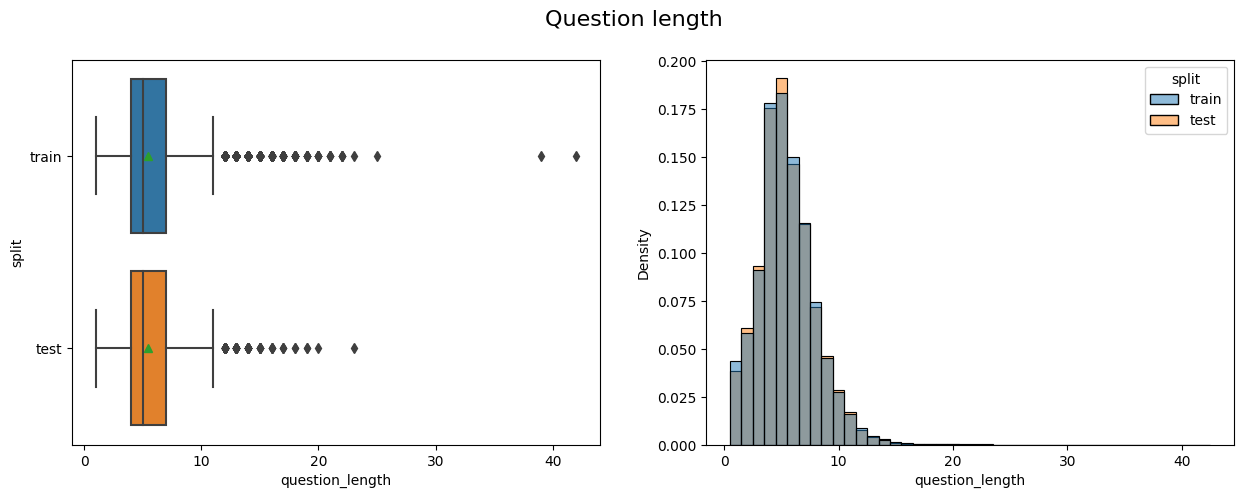

In [21]:
plot_length(qa_dataset, "question");

According to the SQUAD metric, gold and predicted answers are compared after being normalized, i.e. by lowering text, removing articles, punctuation, and double spaces.

answer_length                                          \
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train         946.0  1.003171  0.056254  1.0  1.0  1.0  1.0   
fluency         test         1003.0  3.953141  2.446799  1.0  2.0  3.0  5.0   
                train       13760.0  4.145494  2.911799  1.0  2.0  3.0  5.0   
multiple_choice test           33.0  1.030303  0.174078  1.0  1.0  1.0  1.0   
                train         262.0  1.125954  0.474820  1.0  1.0  1.0  1.0   
span            test         5192.0  2.424307  2.017944  1.0  1.0  2.0  3.0   
                train       71348.0  2.576330  2.762757  0.0  1.0  2.0  3.0   
yes_no          test         1619.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train       20970.0  1.000000  0.000000  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     1.0  
                train    2.0  
fluency         test    18.0  
                train   55.0  
multiple_choice test     2.0  
                train    5.0  
span            test    19.0  
                train  320.0  
yes_no          test     1.0  
                train    1.0

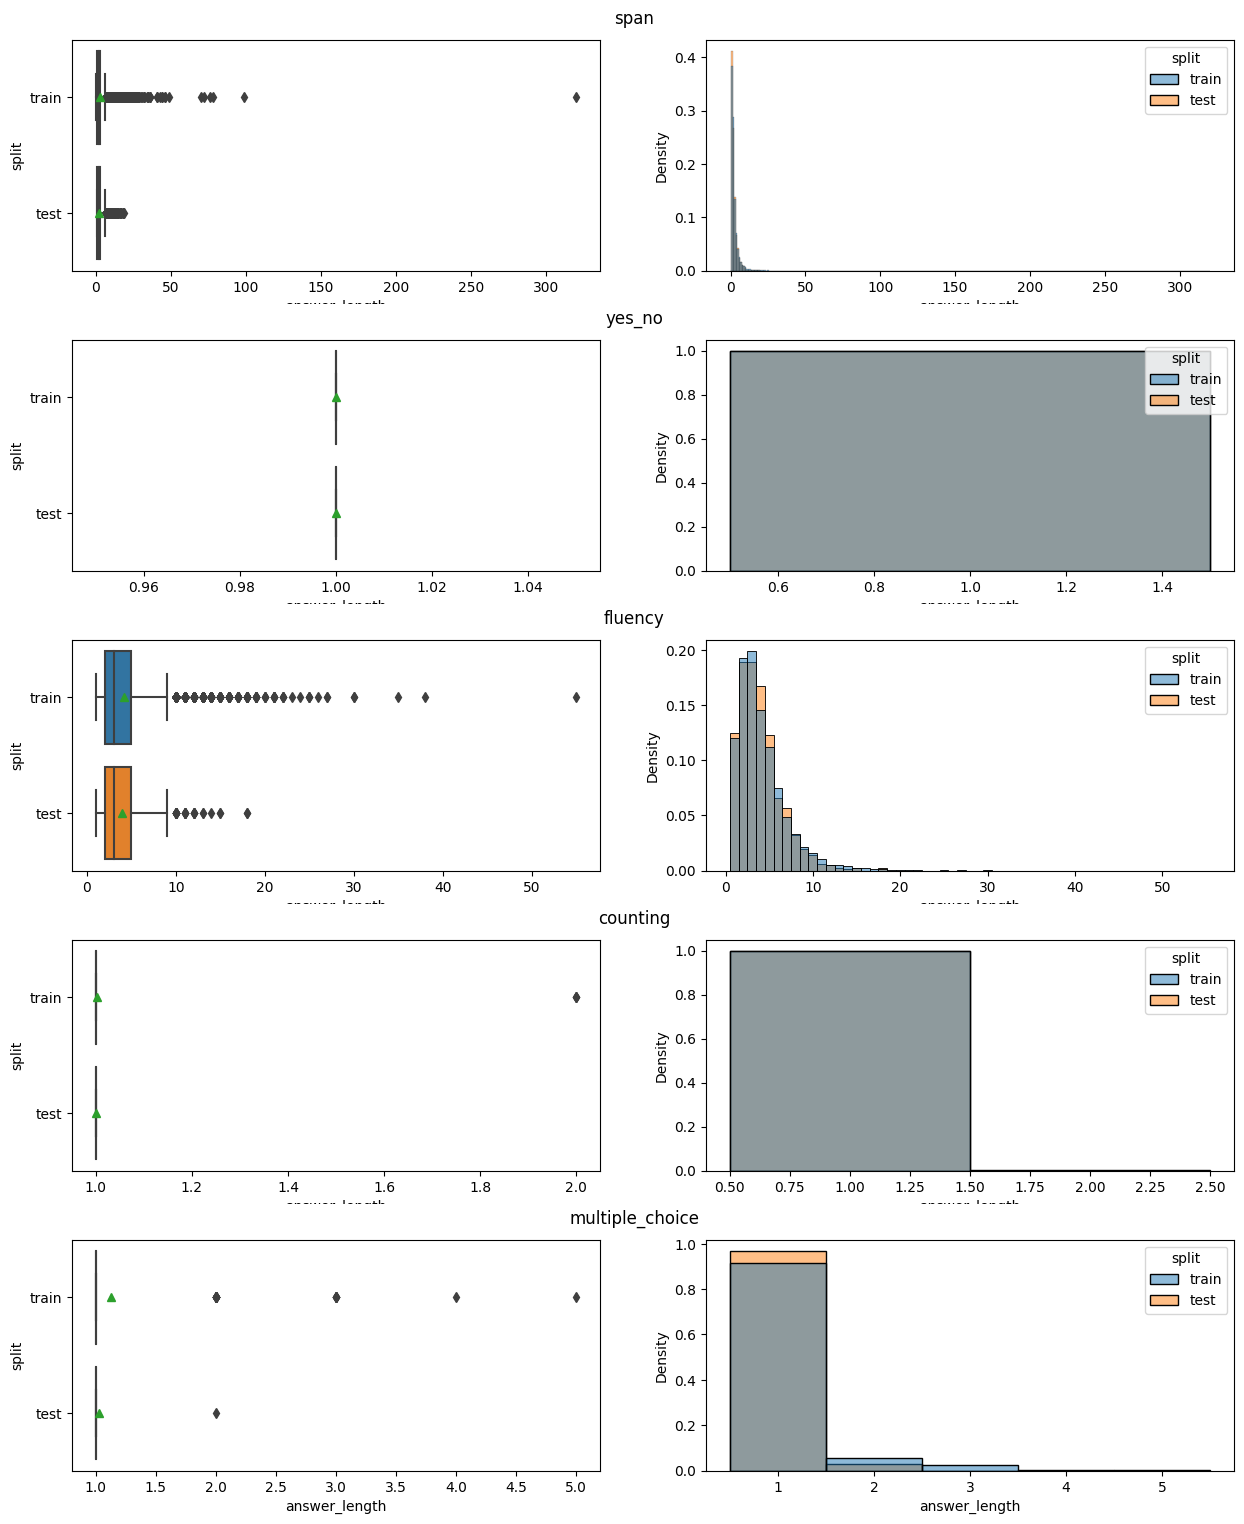

In [22]:
def remove_articles_(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_text(text, remove_articles=False):
    """Lower text and remove punctuation, articles and extra whitespace."""
    text = remove_punc(lower(text))
    if remove_articles:
        text = remove_articles_(text)
    return white_space_fix(text)

def normalize_answer(text):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return normalize_text(text, remove_articles=True)


def plot_answer_length(dataset):
    length_col = "answer" + "_length"
    length = dataset["answer"].str.split().apply(len)
    dp = dataset[["answer_type", "split"]].copy()
    dp[length_col] = length

    display(dp.groupby(["answer_type", "split"]).describe())

    answer_types = AnswerType.list()
    fig = plt.figure(figsize=(15, 3 * len(answer_types)))
    fig.suptitle("Answer length", fontsize=16)

    subfigs = fig.subfigures(nrows=len(answer_types), ncols=1)
    for answer_type, subfig in zip(answer_types, subfigs):
        data = dp[dp["answer_type"] == answer_type]
        subfig.suptitle(answer_type)
        axes = subfig.subplots(1, 2)
        sns.boxplot(data=data,
                    x=length_col,
                    y="split",
                    showmeans=True,
                    ax=axes[0])
        sns.histplot(data,
                     x=length_col,
                     hue="split",
                     stat="density",
                     common_norm=False,
                     discrete=True,
                     ax=axes[1])

qa_dataset["answer"] = qa_dataset["answer"].apply(normalize_answer)
plot_answer_length(qa_dataset)


Let's inspect counting and multiple choice answers whose length is > 1.

In [23]:
def print_readable_questions(data: pd.DataFrame, show_turn=False):
    for _, row in data.iterrows():
        print("id:", row["id"])
        turn = row["turn"] if show_turn else None
        print(get_readable_question(row["question"], row["answer"], row["rationale"], row["answer_type"], turn=turn))
        print()

for answer_type in [AnswerType.COUNTING, AnswerType.MULTIPLE_CHOICE]:
    data = qa_dataset[np.logical_and(qa_dataset["answer_type"] == str(answer_type), qa_dataset["answer"].str.split().apply(len) > 1)]
    print(answer_type)
    print_readable_questions(data)
    print("="*100)

counting
id: 37fmassaycr9w4ms0qgefb1xykpiby
Q		How many petty princely states were absorbed into Himachal? || counting
A		twenty eight || 15 April 1948 as a result of integration of 28 petty princely states

id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How old was he? || counting
A		twenty seven || age of 27

id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How many internationals goals did he have? || counting
A		twenty four ||  24 international goals 

multiple_choice
id: 3tr2532vipuzl3p3mhk6gwu5x1m6j2
Q		Is this story completly made up or based on real life events? || multiple_choice
A		real life events || true story, which he found in a memoir written by a man name

id: 3k3r2qnk8b3vh22vwnrw78ui4spu9e
Q		was instructed to go, or told to think about it? || multiple_choice
A		to think about it ||  I know she said that she would sooner that you were present than all her English friends together. However, you can think about it.

id: 3uxuoq9okex7oa04blcltbri2zna7k
Q		Did the larger one or smaller one get

Multiple choice answers are ok, while counting answers are just wrongly annotated. Indeed, they are span-based answers.

      rationale_length                                                
                 count      mean       std  min  25%  50%   75%    max
split                                                                 
test            7918.0  9.133114  8.820682  1.0  4.0  7.0  12.0  268.0
train         107286.0  9.241252  9.257729  1.0  4.0  7.0  12.0  353.0


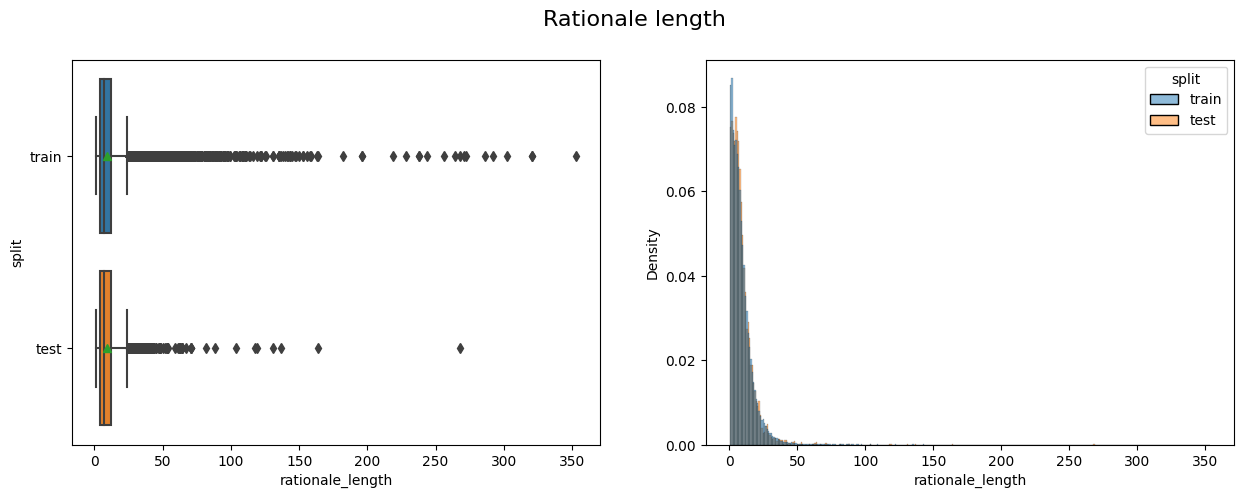

In [24]:
plot_length(qa_dataset, "rationale");

As we can see from the outputs below, very long rationales have no reason to be so lengthy. Indeed, it is likely to be a consequence of poor workmanship.

In [25]:
long_rationales = qa_dataset[qa_dataset["rationale"].str.split().apply(len) > 200]
print("Number of questions with very long rationale:", len(long_rationales))
print()
print_readable_questions(long_rationales)

Number of questions with very long rationale: 17

id: 3ohyz19ugc5e9gs3s7tn4xddsevoa2
Q		Where? || span
A		missouri || Hannibal, Missouri, located on the west bank of the Mississippi. Twain grew up there and was fascinated with (......) life along the river----the steamboats, the giant lumber rafts, and the people who worked on them. 

The Celebrated Jumping Frog of Calaveras County is one of Twain's best loved short stories, and The Adventures of Tom Sawyer is one of his most famous novels. Both these works are celebrated by events held during National Tom Sawyer Days, which originated in the late 1950s and became national in the 1960s. Children enter their frogs in the jumping contest during National Tom Sawyer Days. There's also a fence painting contest to see who can paint the fastest. The idea for this contest comes from a scene in Tom Sawyer, in which Tom has been told to paint the fence in front of the house he lives in. It's a beautiful day, and he would rather be doing anything

In [26]:
data = qa_dataset[qa_dataset["rationale"] == qa_dataset["passage"]]
print("Number of questions with rationale equal to the whole passage:", len(data))
print()
print_readable_questions(data)

Number of questions with rationale equal to the whole passage: 11

id: 3vj40nv2qinjocrcy7k4z235f4yot6
Q		DId someone want to put olives on it? || yes_no
A		no || The children's father wanted to know what every one wanted on their pizza. Andy wanted a strawberry on his pizza. Father thought that was funny. Father asked if anyone wanted chicken on the pizza. Sue did not want chicken. Andy wanted chicken. Dan did not want chicken, but their father wanted to get chicken on the pizza. Dan asked if they could have mushrooms on the pizza. Father did not like mushrooms. Andy and Sue wanted to have mushrooms, so their father had them put mushrooms on the pizza. Sue wanted to have green onions on the pizza. Father also wanted green onions. Dan and Andy did not like green onions, so they did not get green onions on the pizza. Father wanted to order thin crust pizza. Dan thought that thin crust pizza had the taste of an old shoe. Sue thought Dan was wrong. Sue wanted thin crust pizza also. Andy wa

Upon further analysis of the corpus, we observed instances where words at the beginning or at the end of the rationale are truncated. Therefore, we have to fix them if we intend to use the rationale to train the network.

In [27]:
def print_rationales(data: pd.DataFrame):
    for i, row in data.iterrows():
        print("id:", row["id"], "split:", row["split"])
        print("turn:", row["turn"])
        print("R:", row["rationale"], "|", row["span_start"], "-", row["span_end"])
        print("="*100)

def is_rationale_truncated(passage, span_start, span_end):
    if span_start > 0 and passage[span_start].isalnum() and passage[span_start -1].isalnum():
        return True
    
    if span_end < len(passage) and passage[span_end - 1].isalnum() and passage[span_end].isalnum():
        return True
    
    return False

data = qa_dataset[qa_dataset.apply(lambda row: is_rationale_truncated(row["passage"], row["span_start"], row["span_end"]), axis=1)]
print("Number of rationales with errors:", len(data))
print()
print_rationales(data)

Number of rationales with errors: 5572

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R: he Vatican Library is a research library | 454 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R: Scholars have traditionally divided the history of the library into five period | 1048 - 1127
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 11
R: atican Secret Archives were separated from the library at the beginning of the 17th century; | 917 - 1009
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 16
R: hotocopies for private study of pages from books published between 1801 and 1990 | 644 - 724
id: 3bdcf01ogxu7zdn9vlrbf2rqzwplyf split: train
turn: 11
R: the need of a helper, of a friend, of a champio | 751 - 798
id: 3urfvvm165iantk80llvkwwbjs7uzh split: train
turn: 3
R:  Valentina was very pale, and round her eyes there were dark circles that told of sleeplessness, and as she bowed her head in prayer, her ladies observed that tears were falling on the illuminated 

In order to solve the issue, we have to:
1. remove any leading or trailing non alphanumeric character (i.e. spaces, punctuation, etc.) from the rationale.
2. compute new `span_start` and `span_end` indices by considering the entire words.

In [28]:
def strip_non_alphanumeric_chars(text: str):
    """
    Removes trailing and leading non alpha-numeric characters from a given string.
    """
    start_index = 0
    while (start_index < len(text) and not text[start_index].isalnum()):
        start_index += 1

    end_index = len(text) - 1
    while (end_index > start_index and not text[end_index].isalnum()):
        end_index -= 1

    return text[start_index:end_index + 1]


example = " Despite a common background, the groups' views on religious toleration were mixe."
print("Before:", example)
print("After:", strip_non_alphanumeric_chars(example))

qa_dataset_fixed = qa_dataset.copy()
qa_dataset_fixed["rationale"] = qa_dataset_fixed["rationale"].apply(strip_non_alphanumeric_chars)
np.count_nonzero(qa_dataset_fixed["rationale"] != qa_dataset["rationale"])

Before:  Despite a common background, the groups' views on religious toleration were mixe.
After: Despite a common background, the groups' views on religious toleration were mixe


55649

In [29]:
def find_span(passage: str,
              text: str,
              span_start: int = None,
              span_end: int = None):

    if len(text) == 0: return (0, 0)
    assert text[0].isalnum() and text[-1].isalnum(), \
        "Text must begin and end with an alphanumeric character."

    start_idx = passage.find(text, span_start, span_end)
    end_idx = start_idx + len(text) - 1

    if start_idx == -1:
        raise ValueError("The text is not present in the passage.")

    # Find the beginning of the word in the passage
    while (start_idx > 0 and passage[start_idx - 1].isalnum()):
        start_idx -= 1

    # Find the end of the word in the passage
    while (end_idx < len(passage) - 1 and passage[end_idx + 1].isalnum()):
        end_idx += 1

    return start_idx, end_idx + 1


passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = "e Vatican Library is a research lib"
span_start, span_end = find_span(passage, rationale)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "The Vatican Library is a research library"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

print()

passage = " Mandi Marie Utash posted Friday to a GoFundMe.com page [...]\nMandi Marie Utash\twrote that her father doesn't seem to know what happened"
rationale = "andi Marie Utas"
span_start, span_end = find_span(passage,
                                 rationale,
                                 span_start=63,
                                 span_end=78)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "Mandi Marie Utash"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-): e Vatican Library is a research lib
R (+): The Vatican Library is a research library | 1 - 42

P:  Mandi Marie Utash posted Friday to a GoFundMe.com page [...]
Mandi Marie Utash	wrote that her father doesn't seem to know what happened
R (-): andi Marie Utas
R (+): Mandi Marie Utash | 62 - 79


In [30]:
def fix_rationale(passage: str, rationale: str, span_start: int, span_end: int):
    rationale = strip_non_alphanumeric_chars(rationale)
    span_start, span_end = find_span(passage, rationale, span_start=span_start, span_end=span_end)
    return passage[span_start: span_end], span_start, span_end

passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = " e Vatican Library is a research library for history,  "
fixed_rationale, span_start, span_end = fix_rationale(passage, rationale, 1, 100)

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)
assert fixed_rationale == "The Vatican Library is a research library for history"

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-):  e Vatican Library is a research library for history,  
R (+): The Vatican Library is a research library for history | 1 - 54


In [31]:
def _update_dataframe(row):
    fixed_rationale, span_start, span_end = fix_rationale(
        row["passage"], row["rationale"], row["span_start"], row["span_end"])

    row["rationale"] = fixed_rationale
    row["span_start"] = span_start
    row["span_end"] = span_end

    return row


qa_dataset_fixed = qa_dataset.apply(_update_dataframe, axis=1)
diff_start = qa_dataset_fixed["span_start"] != qa_dataset["span_start"]
diff_end = qa_dataset_fixed["span_end"] != qa_dataset["span_end"]
diff_rationale = qa_dataset_fixed["rationale"] != qa_dataset["rationale"]

assert np.all((diff_start | diff_end) == diff_rationale)

data = qa_dataset_fixed[diff_rationale]
print("Number of rationales changed:", len(data))
print()
for i, row in data.iloc[:100].iterrows():
    old_row = qa_dataset[(qa_dataset["id"] == row["id"]) & (qa_dataset["turn"] == row["turn"])]
    assert len(old_row) == 1
    old_row = old_row.iloc[0]

    print("id:", row["id"], "split:", row["split"])
    print("turn:", row["turn"])
    print("R (-):", old_row["rationale"], "|", old_row["span_start"], "-", old_row["span_end"])
    print("R (+):", row["rationale"], "|", row["span_start"], "-", row["span_end"])
    print("="*100)

qa_dataset = qa_dataset_fixed

Number of rationales changed: 58992

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R (-): he Vatican Library is a research library | 454 - 494
R (+): The Vatican Library is a research library | 453 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R (-): Scholars have traditionally divided the history of the library into five period | 1048 - 1127
R (+): Scholars have traditionally divided the history of the library into five periods | 1048 - 1128
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 8
R (-): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat,  | 4 - 94
R (+): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat | 4 - 92
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 9
R (-): is the library of the Holy See, located in Vatican City. | 94 - 150
R (+): is the library of the Holy See, located in Vatican City | 94 - 149
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 

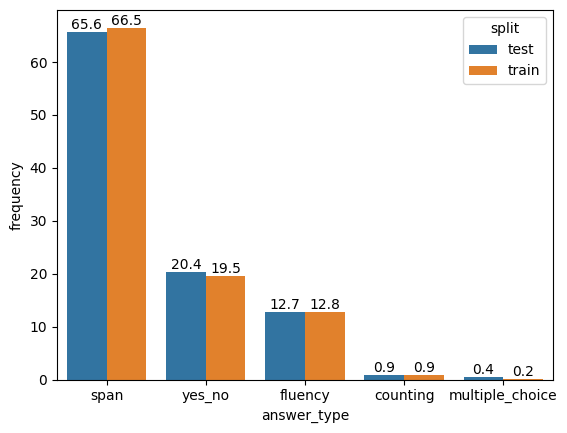

In [32]:
def plot_answer_type_distribution(qa_dataset: pd.DataFrame):
    answer_type_distribution = qa_dataset.groupby(
        "split")["answer_type"].value_counts(normalize=True)
    answer_type_distribution = answer_type_distribution.apply(
        lambda x: np.round(x, decimals=3) * 100)
    answer_type_distribution = answer_type_distribution.rename(
        "frequency").reset_index()
    ax = sns.barplot(answer_type_distribution,
                     x="answer_type",
                     y="frequency",
                     hue="split")

    for i in ax.containers:
        ax.bar_label(i, )


plot_answer_type_distribution(qa_dataset)

In [33]:
for answer_type in AnswerType.list():
    data = qa_dataset[qa_dataset["answer_type"] == answer_type].sample(3)
    print(answer_type)
    print()
    print_readable_questions(data)
    print("=" * 100)

span

id: 3018q3zvoiqh6tkjkzarysii34aary
Q		how old is he? || span
A		19 || The 19-year old lost out to big-serving Croat Marin Cilic, 6-2, 7-5, 7-6 (8/6

id: 36dsne9qz5ypa9v7md60xwgwibpjox
Q		What was Yu's profession? || span
A		writer || Yu Qiuyu is a famous writer

id: 3mb8lzr5bftcf8ysr6qk6ucf2r6lkv
Q		Who is in charge of that group? || span
A		thomas bach || President Thomas Bach

yes_no

id: 3wyp994k17rpgsk28hl9qj9tacfy6m
Q		Did Dick go into the house? || yes_no
A		yes || inside

id: 39ghhavomfrl6glp3trrjyar1iy4jd
Q		Is the PlayStation Store still usable directly? || yes_no
A		no || Sony shut down direct access to the PlayStation Store via PSP

id: 3v5q80fxixr0io4dwuggacw4kvo32n
Q		Did it work? || yes_no
A		no || Let's call to him," went on Tom, and set up a loud cry, in which his brother joined. The pair listened intently, but no answer came back

fluency

id: 3ymu66obin85rqjjauq7garfet8gh8
Q		what was Champagne doing when he met Pele? || fluency
A		he was working at french embas

# [Task 2] Train, test and validation split

In [34]:
train_data = datasets.Dataset.from_pandas(df[df["split"] == "train"].reset_index(drop=True))
test_data = datasets.Dataset.from_pandas(df[df["split"] == "test"].reset_index(drop=True))
dataset = train_data.train_test_split(train_size=0.8, seed=42)
dataset["validation"] = dataset.pop("test")
dataset["test"] = test_data

dataset = dataset.remove_columns("split")
dataset.reset_format()
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'filename', 'passage', 'questions', 'answers', 'qa_length', 'last_turn'],
        num_rows: 5754
    })
    validation: Dataset({
        features: ['id', 'source', 'filename', 'passage', 'questions', 'answers', 'qa_length', 'last_turn'],
        num_rows: 1439
    })
    test: Dataset({
        features: ['id', 'source', 'filename', 'passage', 'questions', 'answers', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


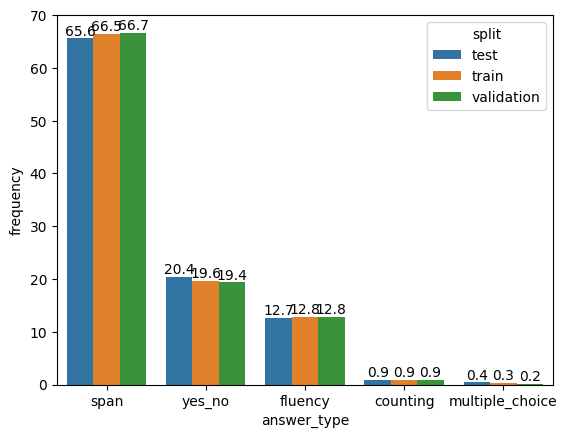

In [35]:
dataset.set_format("pandas")

dataset_ = []
for split, ds in dataset.items():
    split_df = ds[:]
    split_df["split"] = split
    dataset_.append(split_df)
dataset_ = pd.concat(dataset_)

qa_dataset = explode_qa(dataset_)
plot_answer_type_distribution(qa_dataset)

dataset.reset_format()

- Our question-answering model requires three inputs: the passage $P$, the question $Q_i$ and, possibly, the history $H=\left(Q_1, A_1, ..., Q_{i-1}, A_{i-1}\right)$.
- The model generates the answer $A_i$.

To facilitate easy access to these inputs and outputs, we need to organize our dataset accordingly.

In [36]:
def explode_batched_questions(batch):
    examples = [
        explode_questions(dict(zip(batch.keys(), values)))
        for values in zip(*batch.values())
    ]
    
    batch = {
        key: list(itertools.chain(*(example[key] for example in examples)))
        for key in examples[0].keys()
    }
    return batch


def explode_questions(example):
    questions = example.pop("questions")
    answers = example.pop("answers")

    example = {k: [v] * example["qa_length"] for k, v in example.items()}
    example["question"] = questions
    example["answer"] = answers
    histories = []

    qa_pairs = list(zip(questions, answers))
    for idx in range(len(questions)):
        history = [{
            'question': qa_pairs[i][0]['text'],
            'answer': qa_pairs[i][1]['text'],
            'turn': qa_pairs[i][0]['turn']
        } for i in range(idx)]
        histories.append(history)

    example["history"] = histories
    example["history_length"] = [len(history) for history in histories]
    return example


dataset_ = dataset.map(explode_batched_questions,
                       batched=True,
                       remove_columns=["questions", "answers"])
for split, split_dataset in dataset.items():
    assert np.sum(
        split_dataset["qa_length"]) == dataset_[split].num_rows, split

print(dataset_)
dataset_.set_format("pandas")
display(dataset_["train"][:])

dataset = dataset_
dataset.reset_format()
dataset.save_to_disk(dataset_folder)

Map:   0%|          | 0/5754 [00:00<?, ? examples/s]

Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'filename', 'passage', 'qa_length', 'last_turn', 'question', 'answer', 'history', 'history_length'],
        num_rows: 85891
    })
    validation: Dataset({
        features: ['id', 'source', 'filename', 'passage', 'qa_length', 'last_turn', 'question', 'answer', 'history', 'history_length'],
        num_rows: 21395
    })
    test: Dataset({
        features: ['id', 'source', 'filename', 'passage', 'qa_length', 'last_turn', 'question', 'answer', 'history', 'history_length'],
        num_rows: 7918
    })
})


,id,source,filename,passage,qa_length,last_turn,question,answer,history,history_length
0,3uj1cz6izhpw128f4sjfgr7sxzys5i,race,middle268.txt,Jack Johnson is one of the most popular singer...,20,20,"{'question_type': 'span', 'text': 'What did Ja...","{'answer_type': 'span', 'rationale': ' a profe...",[],0
1,3uj1cz6izhpw128f4sjfgr7sxzys5i,race,middle268.txt,Jack Johnson is one of the most popular singer...,20,20,"{'question_type': 'yes_no', 'text': 'Did he su...","{'answer_type': 'yes_no', 'rationale': 'Jack n...","[{'answer': 'professional surfer', 'question':...",1
2,3uj1cz6izhpw128f4sjfgr7sxzys5i,race,middle268.txt,Jack Johnson is one of the most popular singer...,20,20,"{'question_type': 'yes_no', 'text': 'Did he do...","{'answer_type': 'yes_no', 'rationale': 'Jack e...","[{'answer': 'professional surfer', 'question':...",2
3,3uj1cz6izhpw128f4sjfgr7sxzys5i,race,middle268.txt,Jack Johnson is one of the most popular singer...,20,20,"{'question_type': 'span', 'text': 'What compet...","{'answer_type': 'span', 'rationale': 'the fina...","[{'answer': 'professional surfer', 'question':...",3
4,3uj1cz6izhpw128f4sjfgr7sxzys5i,race,middle268.txt,Jack Johnson is one of the most popular singer...,20,20,"{'question_type': 'span', 'text': 'At waht age...","{'answer_type': 'span', 'rationale': 'At the a...","[{'answer': 'professional surfer', 'question':...",4
...,...,...,...,...,...,...,...,...,...,...
85886,36u2a8vag1zwf75ralfa02ebb91ykx,wikipedia,Methodism.txt,Methodism or the Methodist movement is a group...,20,20,"{'question_type': 'span', 'text': 'Why?', 'tur...","{'answer_type': 'span', 'rationale': 'for all ...","[{'answer': 'sanctification', 'question': 'Wha...",15
85887,36u2a8vag1zwf75ralfa02ebb91ykx,wikipedia,Methodism.txt,Methodism or the Methodist movement is a group...,20,20,"{'question_type': 'span', 'text': 'What does M...","{'answer_type': 'span', 'rationale': 'charity'...","[{'answer': 'sanctification', 'question': 'Wha...",16
85888,36u2a8vag1zwf75ralfa02ebb91ykx,wikipedia,Methodism.txt,Methodism or the Methodist movement is a group...,20,20,"{'question_type': 'span', 'text': 'What else?'...","{'answer_type': 'span', 'rationale': 'support ...","[{'answer': 'sanctification', 'question': 'Wha...",17
85889,36u2a8vag1zwf75ralfa02ebb91ykx,wikipedia,Methodism.txt,Methodism or the Methodist movement is a group...,20,20,"{'question_type': 'span', 'text': 'How do they...","{'answer_type': 'span', 'rationale': 'the esta...","[{'answer': 'sanctification', 'question': 'Wha...",18


Saving the dataset (0/1 shards):   0%|          | 0/85891 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21395 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7918 [00:00<?, ? examples/s]

# [Task 3] Model definition

In [37]:
DISTIL_ROBERTA = "distilroberta-base" # T=512
BERT_TINY = "prajjwal1/bert-tiny"

In [ ]:
# class CoQAEncoderDecoderModel(nn.Module):
#     def __init__(self, encoder, decoder) -> None:
#         super().__init__()

class BertRationaleEncoder(nn.Module):
    def __init__(self, encoder, config) -> None:
        super().__init__()
        self.encoder = encoder
        self.rationale_head = RationaleHead(config)

class RationaleHead(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size, bias=True)
        if isinstance(config.hidden_act, str):
            self.act_fn = transformers.modeling_utils.get_activation(config.hidden_act)
        else:
            self.act_fn = config.hidden_act
        self.hidden_to_logit = nn.Linear(config.hidden_size, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.act_fn(hidden_states)
        logits = self.hidden_to_logit(hidden_states)
        p_rationale = self.sigmoid(logits)
        return p_rationale



In [78]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(BERT_TINY, BERT_TINY)
print(model)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_af

In [51]:
encoder = transformers.BertGenerationEncoder.from_pretrained(BERT_TINY,
                                                             bos_token_id=101,
                                                             eos_token_id=102)

# add cross attention layers and use BERT's cls token as BOS token and sep token as EOS token

decoder = transformers.BertGenerationDecoder.from_pretrained(
    BERT_TINY,
    add_cross_attention=True,
    is_decoder=True,
    bos_token_id=101,
    eos_token_id=102)

bert2bert = EncoderDecoderModel(encoder=encoder, decoder=decoder)
print(bert2bert)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertGenerationEncoder: ['cls.predictions.decoder.weight', 'bert.pooler.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'bert.embeddings.token_type_embeddings.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertGenerationEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertGenerationEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassi

EncoderDecoderModel(
  (encoder): BertGenerationEncoder(
    (embeddings): BertGenerationEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertGenerationLayer(
          (attention): BertGenerationAttention(
            (self): BertGenerationSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertGenerationSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [77]:
print(model.decoder.base_model_prefix)
model.decoder

bert


BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=Tr

In [47]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(DISTIL_ROBERTA, DISTIL_ROBERTA)
print(model)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encoder.layer.5.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.3.crossa

EncoderDecoderModel(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [1]:
dataset = datasets.load_from_disk(dataset_folder)
dataset

NameError: name 'datasets' is not defined

In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

optimizer = AdamW(model.parameters(), lr=3e-5)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

checkpoints_dir = "bert-tiny-coqa"
training_args = TrainingArguments(checkpoints_dir, evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
samples = tokenized_datasets["train"]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}

In [ ]:
checkpoint = "bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch = data_collator(samples)

In [ ]:
### NEED TO FIX THE HISTORY CREATION


def unpack_qna(df, history_len):
    unpacked_df = []

    for _, row in df.iterrows():
        history = ''
        qa_pairs = list(zip(row['questions'], row['answers']))
        for idx, (question, answer) in enumerate(qa_pairs):
            history = ''.join([
                qa_pairs[i][0]['text'] + ' ' +
                qa_pairs[i][1]['text'] + '. '
                for i in range(max(0, idx - history_len), idx)
            ])
            data = {
                'source': row['source'],
                'passage': row['passage'],
                'question': question['text'],
                'answer': answer['text'],
                'rationale': answer['rationale'],
                'span_start': answer['span_start'],
                'span_end': answer['span_end'],
                'history': history
            }
            unpacked_df.append(data)

    unpacked_df = pd.DataFrame(unpacked_df)
    unpacked_df.reset_index(drop=True, inplace=True)

    return unpacked_df


train_data = unpack_qna(df_train, 3)
val_data = unpack_qna(df_val, 3)
test_data = unpack_qna(df_test, 3)

In [ ]:
train_data.head()

,source,passage,question,answer,rationale,span_start,span_end,history
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475,151,179,
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library,454,494,When was the Vat formally opened? It was forma...
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...,457,511,When was the Vat formally opened? It was forma...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...,457,545,When was the Vat formally opened? It was forma...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi...",769,879,what is the library for? research. for what su...


## Stuff

As first thing, we had to chose the the maximum length doing a good trade-off within too long inputs and truncate too many and looging information. 

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# input = train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_no_hist = input.map(lambda text: len(tokenizer(text).input_ids))

# input = train_data['history'] + train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_hist = input.map(lambda text: len(tokenizer(text).input_ids))

# plt.figure(figsize=(20, 5))
# plt.subplot(1, 2, 1)
# plt.hist(num_tokens_no_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_no_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_no_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa no hist')

# plt.subplot(1, 2, 2)
# plt.hist(num_tokens_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa with hist')
# plt.show()

Choosing 512 as max length, more than 95% of the input can be represented.

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# input = train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_no_hist = input.map(lambda text: len(tokenizer(text).input_ids))

# input = train_data['history'] + train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_hist = input.map(lambda text: len(tokenizer(text).input_ids))

# plt.figure(figsize=(20, 5))
# plt.subplot(1, 2, 1)
# plt.hist(num_tokens_no_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_no_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_no_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa no hist')

# plt.subplot(1, 2, 2)
# plt.hist(num_tokens_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa with hist')
# plt.show()

# [Task 3] Model definition

In [ ]:
model_checkpoints = "prajjwal1/bert-tiny"
ed = EncoderDecoderModel.from_encoder_decoder_pretrained(
    model_checkpoints, model_checkpoints, tie_encoder_decoder=True)

print(ed)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_af

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_checkpoints = "prajjwal1/bert-tiny"


class GenerativeModel(torch.nn.Module):

    def __init__(self, name, model_checkpoints, device, **kwargs):
        super(GenerativeModel, self).__init__(**kwargs)
        self.name = name
        self.device = device

        # Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)

        # Encoder-Decoder model that its used as a generator for answer
        self.generator = EncoderDecoderModel.from_encoder_decoder_pretrained(
            model_checkpoints, model_checkpoints, tie_encoder_decoder=True)
        # decoder configuration
        self.generator.config.decoder.is_decoder = True
        self.generator.config.decoder.add_cross_attention = True

        # model configuration
        self.generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
        self.generator.config.eos_token_id = self.tokenizer.sep_token_id
        self.generator.config.pad_token_id = self.tokenizer.pad_token_id
        self.generator.config.vocab_size = self.generator.config.decoder.vocab_size

        # Generation parameters
        self.generator.config.max_length = 64
        self.generator.config.min_length = 2
        self.generator.config.no_repeat_ngram_size = 3
        self.generator.config.finetuning_task = True
        self.generator.config.repetition_penalty = 3.0
        self.generator.config.num_beams = 10

    def forward(self, inputs, labels, **kwargs):
        # Train on Question & Answer
        loss = self.generator(input_ids=inputs["input_ids"],
                              attention_mask=inputs["attention_mask"],
                              labels=labels).loss

        return loss

    def generate(self, inputs, **kwargs):
        # Predict Answer from Question
        pred_answer = self.generator.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"])

        return pred_answer

In [ ]:
class TokenizedDataset(Dataset):

    def __init__(self, df, model, encoder_max_len=512, decoder_max_len=32):
        super(TokenizedDataset).__init__()
        self.df = df
        self.name = model.name
        self.tokenizer = model.tokenizer
        #self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        passage = row.passage
        # history = row.history
        question = row.question
        answer = row.answer
        rationale = row.rationale

        start_idx = row.span_start
        end_idx = row.span_end

        # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] [PAD]*
        input_encoding = self.tokenizer(
            question,
            passage,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        # OUTPUT: [CLS] ANSWER [SEP] [PAD]
        output_encoding = self.tokenizer(answer,
                                         truncation=True,
                                         padding='max_length',
                                         max_length=self.decoder_max_len)

        labels = output_encoding.input_ids

        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [
            -100 if token == self.tokenizer.pad_token_id else token
            for token in labels
        ]
        labels = torch.tensor(labels, dtype=torch.int64)

        inputs = {
            'input_ids':
            torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask':
            torch.tensor(input_encoding.attention_mask, dtype=torch.int64),           
            #rationale
            'rat_start_idx':
            torch.tensor(start_idx, dtype=torch.int64),
            'rat_end_idx':
            torch.tensor(end_idx, dtype=torch.int64)
        }

        return inputs, labels

### Training

In [ ]:
def train_model(model,
                train_data,
                val_data,
                epochs=3,
                save_path="bert_tiny"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Creating datasets...")
    train_dataset = TokenizedDataset(train_data, model)
    val_dataset = TokenizedDataset(val_data, model)

    # Prepare DataLoaders
    print("Creating dataloaders...")
    train_loader = create_reproducible_dataloader(train_dataset,
                              batch_size=32,
                              drop_last=False,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True
                              )
    val_loader = create_reproducible_dataloader(val_dataset,
                            batch_size=32,
                            drop_last=False,
                            shuffle=True,
                            num_workers=2,
                            pin_memory=True
                            )

    optimizer = AdamW(model.generator.parameters(), lr=5e-5)

    train_loss, val_loss = [], []
    tot_steps = 0
    model.to(device)

    print("Training...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad()

        # train step
        # for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            loss = model.forward(inputs, labels)

            epoch_loss += float(loss)
            tot_steps += labels.shape[0]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)

        # validation step
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                # Forward pass
                loss = model.forward(inputs, labels)

                # Accumulate loss
                epoch_val_loss += float(loss)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(
            f'Epoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}'
        )

    if save_path is not None:
        torch.save(model, save_path)
        del model

    return train_loss, val_loss


train_test = train_data[:128]
val_test = train_data[:128]

generative_model = GenerativeModel('BERTTiny', "prajjwal1/bert-tiny", device=device)
history = train_model(generative_model, train_data, val_data)
# history = train_model(M2, train_test, val_test)
print("Train complete")

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Creating datasets...
Creating dataloaders...
Training...


In [23]:
class model(torch.nn.Module):

    def __init__(self, name, model_checkpoints, **kwargs):
        super(model, self).__init__(**kwargs)
        self.name = name
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

        # Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)

        # Encoder-Decoder model that its used as a generator for answer
        self.generator = EncoderDecoderModel.from_encoder_decoder_pretrained(
            model_checkpoints, model_checkpoints, tie_encoder_decoder=True)
        # Rationale extractor
        self.extractor = AutoModelForQuestionAnswering.from_pretrained(
            model_checkpoints)

        # decoder configuration
        self.generator.config.decoder.is_decoder = True
        self.generator.config.decoder.add_cross_attention = True

        # model configuration
        self.generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
        self.generator.config.eos_token_id = self.tokenizer.sep_token_id
        self.generator.config.pad_token_id = self.tokenizer.pad_token_id
        self.generator.config.vocab_size = self.generator.config.decoder.vocab_size

        # Generation parameters
        self.generator.config.max_length = 64
        self.generator.config.min_length = 2
        self.generator.config.no_repeat_ngram_size = 3
        self.extractor.config.finetuning_task = True
        self.generator.config.finetuning_task = True
        self.generator.config.repetition_penalty = 3.0
        self.generator.config.num_beams = 10

    def forward(self, inputs, labels):
        # predict rationale with Q and P: [CLS] Q [SEP] P [SEP] [PAD]* -> rat_start_idx, rat_end_idx
        pred_rat_idxs = self.extractor(input_ids=inputs["input_ids"],
                                       attention_mask=inputs["attention_mask"],
                                       start_positions=inputs["rat_start_idx"],
                                       end_positions=inputs["rat_end_idx"])

        # get predicted start, end indexs
        pred_rat_s_idx = torch.argmax(pred_rat_idxs.start_logits, dim=-1)
        pred_rat_e_idx = torch.argmax(pred_rat_idxs.end_logits, dim=-1)

        ### EXTRAT PREDICTED RATIONALES
        ### if the start and end rationale index are completly wrong, just use Question and Passage for train
        if pred_rat_s_idx < pred_rat_e_idx and pred_rat_e_idx < inputs[
                'input_ids'].shape[-1]:
            new_inputs = inputs["input_ids"].cpu().numpy()
            max_length = inputs['input_ids'].shape[-1]

            # get the predict rationale  input = [CLS] Q [SEP] P [SEP] [PAD]* -> P[pred_rat_s_idx:pred_rat_e_idx] / P
            pred_rat = list(
                map(
                    lambda x, s_idx, e_idx: x[s_idx:e_idx]
                    if e_idx < max_length and s_idx < e_idx else x[np.where(
                        x == self.tokenizer.sep_token_id)[0][0] + 1:np.where(
                            x == self.tokenizer.sep_token_id)[0][0] + 1:],
                    inputs["input_ids"], pred_rat_s_idx, pred_rat_e_idx))

        else:
            gen_loss = self.generator(input_ids=inputs["input_ids"],
                                      attention_mask=inputs["attention_mask"],
                                      labels=labels).loss

        # get the question_ids input = [CLS] Q [SEP] P [SEP] [PAD]* -> [CLS] Q [SEP]
        #q_ids = list(map(lambda x: x[:torch.where(x == sep_token)[0][0] + 1], inputs["input_ids"]))

        ### RECONSTRUCT INPUT FOR THE 2ND NETWORK
        ### if rat found -> [CLS] Q [SEP] R [SEP] [PAD]
        ### if rat = ''  -> [CLS] Q [SEP] P [SEP] [PAD]
        new_inputs = list(
            map(
                lambda x, q, r: torch.cat(
                    (q, r, sep_token,
                     torch.tensor([pad_token] * (max_length - len(q) - len(r) -
                                                 1)).to(self.device)))
                if r is not None else x, inputs["input_ids"], q_ids, pred_rat))

        new_inputs = torch.stack(new_inputs).to(self.device)
        new_att_mask = torch.tensor(torch.where(new_inputs != pad_token, 1, 0),
                                    dtype=torch.int64).to(self.device)

        ### Predict from question and generated rationale
        gen_loss = self.generator(input_ids=new_inputs,
                                  attention_mask=new_att_mask,
                                  labels=labels).loss

        return gen_loss + pred_rat_idxs.loss

    def generate(self, inputs, **kwargs):
        sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(self.device)
        pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(self.device)
        max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(
            self.device)

        # predict rationale with Q and P: [CLS] Q [SEP] P [SEP] [PAD]* -> rat_start_idx, rat_end_idx
        pred_rat_idxs = self.extractor(input_ids=inputs["input_ids"],
                                       attention_mask=inputs["attention_mask"])

        # get predicted start, end indexs
        pred_rat_s_idx = torch.argmax(pred_rat_idxs.start_logits, dim=-1)
        pred_rat_e_idx = torch.argmax(pred_rat_idxs.end_logits, dim=-1)

        ### EXTRAT PRED RATIONALE

        # get the question_ids input = [CLS] Q [SEP] P [SEP] [PAD]* -> [CLS] Q [SEP]
        q_ids = list(
            map(lambda x: x[:torch.where(x == sep_token)[0][0] + 1],
                inputs["input_ids"]))

        # get the predict rationale  input = [CLS] Q [SEP] P [SEP] [PAD]* -> P[pred_rat_s_idx:pred_rat_e_idx] / None
        pred_rat = list(
            map(
                lambda x, q, s_idx, e_idx: x[len(q) + s_idx:len(q) + e_idx]
                if len(q) + s_idx < max_length and s_idx < e_idx else None,
                inputs["input_ids"], q_ids, pred_rat_s_idx, pred_rat_e_idx))

        ### RECONSTRUCT INPUT FOR THE 2ND NETWORK
        ### if rat found -> [CLS] Q [SEP] R [SEP] [PAD]
        ### if rat = ''  -> [CLS] Q [SEP] P [SEP] [PAD]
        new_inputs = list(
            map(
                lambda x, q, r: torch.cat(
                    (q, r, sep_token,
                     torch.tensor([pad_token] * (max_length - len(q) - len(r) -
                                                 1)).to(self.device)))
                if r is not None else x, inputs["input_ids"], q_ids, pred_rat))

        new_inputs = torch.stack(new_inputs).to(self.device)
        new_att_mask = torch.tensor(torch.where(new_inputs != pad_token, 1, 0),
                                    dtype=torch.int64).to(self.device)

        ### Predict from question and generated rationale
        pred_answer = self.generator.generate(input_ids=new_inputs,
                                              attention_mask=new_att_mask)

        return pred_answer


Create custom dataset for train


In [46]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

In [70]:
row = train_data.iloc[3500]
q = row.question
p = row.passage
s_start = row.span_start
s_end = row.span_end

ids = np.array(
    tok(q, p, padding='max_length', truncation=True,
        max_length=128)["input_ids"])
#print("ids: ", ids)
print("ids_dec:", tok.decode(ids))
print("span idx: ", s_start, s_end)
print("span: ", p[s_start:s_end])
print("pred_span: ", tok.decode(ids[s_start:s_end]))

new_p = np.array(
    tok(p[:s_start] + tok.sep_token + p[s_start:s_end] + tok.sep_token +
        p[s_end + 1:]).input_ids)
i_s, i_e = np.where(new_p == tok.sep_token_id)[0][0], np.where(
    new_p == tok.sep_token_id)[0][1]
print("pred_span2: ", tok.decode(ids[i_s:i_e]))

q_len = len(ids[:np.where(ids == tok.sep_token_id)[0][0]])
print("pred_span3: ", tok.decode(ids[q_len + i_s:q_len + i_e - 1]))


ids_dec: [CLS] before him, who were they talking to? [SEP] chapter iii in the low country master lirriper had stood apart while the boys were conversing with francis vere. " what do you think, master lirriper? " geoffrey exclaimed as they joined him. " we have asked mr. vere to take us with him as pages to the war in the low country, and though he said we were not to be hopeful about his reply, i do think he will take us. we are to go round to westminster at one o'clock to see him again. what do you think of that? " " i [SEP]
span idx:  103 115
span:  Francis Vere
pred_span:  go round to westminster at one o'clock to see him
pred_span2:  stood apart while the
pred_span3:  francis vere


In [ ]:
class TokenizedDataset(Dataset):

    def __init__(self, df, model, encoder_max_len=512, decoder_max_len=32):
        super(TokenizedDataset).__init__()
        self.df = df
        self.name = model.name
        self.tokenizer = model.tokenizer
        #self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        passage = row.passage
        history = row.history
        question = row.question
        answer = row.answer
        rationale = row.rationale

        start_idx = row.span_start
        end_idx = row.span_end

        # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] [PAD]*
        input_encoding = self.tokenizer(
            question,
            passage,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        rationale_encoding = self.tokenizer(
            question,
            rationale,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        # OUTPUT: [CLS] ANSWER [SEP] [PAD]
        output_encoding = self.tokenizer(answer,
                                         truncation=True,
                                         padding='max_length',
                                         max_length=self.decoder_max_len)

        labels = output_encoding.input_ids

        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [
            -100 if token == self.tokenizer.pad_token_id else token
            for token in labels
        ]
        labels = torch.tensor(labels, dtype=torch.int64)

        inputs = {
            'input_ids':
            torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask':
            torch.tensor(input_encoding.attention_mask, dtype=torch.int64),
            'rationale_ids':
            torch.tensor(rationale_encoding.input_ids, dtype=torch.int64),
            'rationlale_mask':
            torch.tensor(rationale_encoding.attention_mask, dtype=torch.int64),
            'rat_start_idx':
            torch.tensor(start_idx, dtype=torch.int64),
            'rat_end_idx':
            torch.tensor(end_idx, dtype=torch.int64)
        }

        return inputs, labels

## Training


In [ ]:
def train_model(model,
                train_data,
                val_data,
                validation=True,
                save_path="bert_tiny"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = TokenizedDataset(train_data, model)
    val_dataset = TokenizedDataset(val_data, model)

    # Prepare DataLoaders
    train_loader = create_reproducible_dataloader(train_dataset,
                              batch_size=32,
                              drop_last=False,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True)
    val_loader = create_reproducible_dataloader(val_dataset,
                            batch_size=32,
                            drop_last=False,
                            shuffle=True,
                            num_workers=2,
                            pin_memory=True)

    optimizer = AdamW(model.generator.parameters(), lr=5e-5)

    train_loss, val_loss = [], []
    tot_steps = 0
    model.to(device)

    for epoch in range(3):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad()

        # train step
        for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            loss = model.forward(inputs, labels)

            epoch_loss += float(loss)
            tot_steps += labels.shape[0]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #gc.collect()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)

        # validation step
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                # Forward pass
                loss = model.forward(inputs, labels)

                # Accumulate loss
                epoch_val_loss += float(loss)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(
            f'Epoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}'
        )

    if save_path is not None:
        torch.save(model, save_path)
        del model

    return train_loss, val_loss


# train_test = train_data[:128]
# val_test = train_data[:128]

M2 = model('BERTTiny', "prajjwal1/bert-tiny")
history = train_model(M2, train_data, val_data)
# history = train_model(M2, train_test, val_test)
print("Train complete")

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

  0%|          | 0/2682 [00:00<?, ?it/s]

<ipython-input-22-00569c1a2899>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_att_mask = torch.tensor(torch.where(new_inputs != pad_token, 1, 0), dtype=torch.int64).to(self.device)


  0%|          | 0/671 [00:00<?, ?it/s]

Epoch = 0: train_loss = 10.4384; val_loss = 9.9264


  0%|          | 0/2682 [00:00<?, ?it/s]

RuntimeError: ignored

## Eval

In [ ]:
def eval_model(model, dataset, **kwargs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    tokenize_dataset = TokenizedDataset(dataset, model)
    dataloader = DataLoader(tokenize_dataset,
                            batch_size=32,
                            drop_last=False,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

    pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = torch.tensor([[
                model.tokenizer.pad_token_id if token == -100 else token
                for token in label
            ] for label in labels],
                                  dtype=torch.int64)
            labels = labels.to(device)

            # Forward pass
            pred_ids = model.generate(inputs, **kwargs)

            pred.extend(
                model.tokenizer.batch_decode(pred_ids,
                                             skip_special_tokens=True))

    # F1-score
    f1_scores = list(
        map(lambda p, a: squad.compute_f1(p, a), pred, dataset['answer']))

    return np.mean(f1_scores)


f1 = eval_model(M2, val_test)
print(f"Avg F1-score = {f1:.4f}\n")

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-22-00569c1a2899>:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_att_mask = torch.tensor(torch.where(new_inputs != pad_token, 1, 0), dtype=torch.int64).to(self.device)


Avg F1-score = 0.1042



In [ ]:
torch.cuda.empty_cache()